# Double-cantilever-beam: ERR calculation

Consider a DCB of length $L=1$ thickness $H=0.3 L$, with a crack of length $L_c$

1. For $L_c=0.5$:

    (a) Solve the elastic problem for imposed displacement
    
    (b) Plot the crack opening displacement in a neighborhood of the crack tip; deduce from the crack opening displacement a first estimate of the energy relase rate.
    
    (c) Plot the stress $\sigma_{\theta\theta}$ in a neighborhood of the crack tip; deduce from the stress $\sigma_{\theta\theta}$ a second estimate of the energy relase rate.
    
    (d) Calculate the energy release as a finite difference approximation of the potential energy
    
    
2. For $L\in[0.2,0.8]$:
    - Calculate the potential energy as a function of $L_c$ and obtain the corresponding finite-difference approximation of the energy release rate.
    - Plot the force-displacement diagram. 
    - Give the crack evolution law for the crack as a function of the loading for the case of applied displacement
    - Give the crack evolution law for the crack as a function of the loading for the case of applied force

In [1]:
import dolfin 
import mshr
import ufl
import matplotlib.pyplot as plt
import numpy as np
import mshr
%config Completer.use_jedi = False
%config IPCompleter.greedy = True

# Basic example

## Useful functions

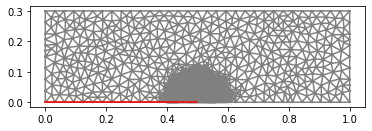

In [6]:
def generate_mesh(Lc=0.5,n_div=20,n_ref=4,R_ref=0.1,Lx=1.0,H1=0.3,H2=0.3):
    """
    Generate a polygonal mesh with:
        - Lc : crack length
        - n_div : number of divisions on the largest side
        - n_ref : number of refinements around the crack
        - r_ref : Radius for refinement around the crack
        - Lx : Length
        - H1 : Left side
        - H2 : Rigth side
    """
    p0 = dolfin.Point(0,0)
    pc = dolfin.Point(Lc,0)
    p1 = dolfin.Point(Lx,0)
    p2 = dolfin.Point(Lx,H2)
    p3 = dolfin.Point(0,H1)
    geom = mshr.Polygon([p0,pc,p1,p2,p3])
    mesh = mshr.generate_mesh(geom,n_div)
    
    for i in range(n_ref):
        cell_markers = dolfin.MeshFunction("bool", mesh, mesh.topology().dim())
        cell_markers.set_all(False)
        for cell in dolfin.cells(mesh):
            if cell.midpoint().distance(pc) < R_ref :
                cell_markers[cell] = True
        mesh = dolfin.refine(mesh, cell_markers)
    
    return mesh 

Lc = 0.5
Lx = 1.
mesh = generate_mesh(Lc=0.5,n_div=20,n_ref=5,R_ref=0.1,Lx=Lx,H1=0.3,H2=0.3)
dolfin.plot(mesh)
plt.plot([0,Lc],[0,0],"-r")

def eps(u):
    return dolfin.sym(dolfin.grad(u))

def sigma(epsilon):
    # Elasticity parameters
    mu = E/(2*(1.0 + nu)) # lame 1 (plane-strain)
    lmbda = E*nu/((1.0 + nu)*(1.0 -2.0*nu)) # lame 2 (plane-strain) 
    return  2*mu*epsilon + lmbda*dolfin.tr(epsilon)*dolfin.Identity(2)




## Solve linear elasticity 

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


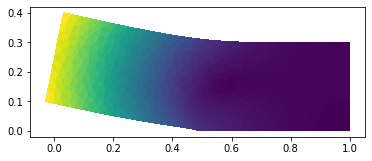

In [7]:
V = dolfin.VectorFunctionSpace(mesh, "Lagrange", 2)

# Boundary conditions
u0 = dolfin.Constant(0.0)
u1 = dolfin.Constant(1)
bc_bottom = dolfin.DirichletBC(V.sub(1), u0, f"on_boundary & near(x[1],0) && x[0] > {Lc}")
bc_left = dolfin.DirichletBC(V.sub(1), u1, "on_boundary & near(x[0],0)")
bc_right = dolfin.DirichletBC(V.sub(0), u0, f"on_boundary & near(x[0],{Lx})")
bcs = [bc_right, bc_bottom, bc_left]

# Elasticity parameters
E = dolfin.Constant(10) # Young
nu = dolfin.Constant(0.3) # Poisson

# Variational formulation of the problem 

u = dolfin.TrialFunction(V)
v = dolfin.TestFunction(V)

# bilinear form
a = dolfin.inner(sigma(eps(u)), eps(v)) * dolfin.dx 

# linear form

# Bulk load 
bulk_load = dolfin.Constant((0.,0.))
L = dolfin.inner(bulk_load,v) * dolfin.dx

A = dolfin.assemble(a)
b = dolfin.assemble(L)
for bc in bcs:
    bc.apply(A,b)

usol = dolfin.Function(V)
dolfin.solve(A,usol.vector(),b) 

dolfin.plot(.1 * usol, mode="displacement")

## Elastic energy 

In [8]:
energy = dolfin.assemble(dolfin.inner(sigma(eps(usol)), eps(usol)) * dolfin.dx)
print(f"The elastic energy is {energy}")

The elastic energy is 0.21366174647679978


## Crack opening displacement

Text(0, 0.5, 'Crack opening displacement')

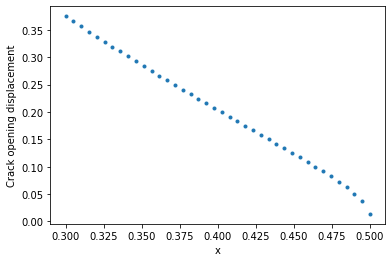

In [9]:
xs = np.linspace(0.3,0.5,40)
us = np.array([usol(x,0)[1] for x in xs])
plt.plot(xs,us,".")
plt.xlabel("x")
plt.ylabel("Crack opening displacement")

In [10]:
r = (Lc-xs)
r_ = r[np.where(xs<Lc)]
us_ = us[np.where(xs<Lc)]

<ipython-input-11-a50856af8f9b>:7: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogx(r,us*np.sqrt(2*np.pi/r)*factor,".")


Text(0.5, 1.0, 'Crack opening displacement')

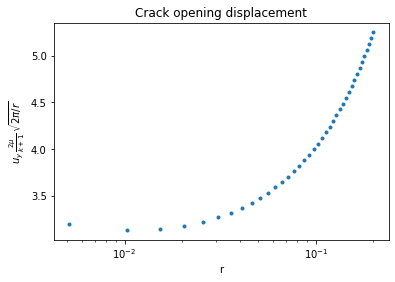

In [11]:
nu = 0.3
E = 10.
kappa = (3 - nu) / (1 + nu)
mu = E/(2*(1.0 + nu))
factor = 2 * mu / (kappa + 1)

plt.semilogx(r,us*np.sqrt(2*np.pi/r)*factor,".")
plt.xlabel("r")
plt.ylabel(r"${u_y} \,\frac{2\mu}{k+1} \,\sqrt{2\pi/r}$")
plt.title("Crack opening displacement") 

Estimate of the $K_I$ and the energy release rate from the crack openingg displacement 

In [12]:
KI_estimate = 3.1 
G_estimate = KI_estimate ** 2 / E # Irwin's formula in plane stress
print(f"KI_estimate is {KI_estimate}, ERR estimate is {G_estimate}")

KI_estimate is 3.1, ERR estimate is 0.9610000000000001


## Crack-tip Stress

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


Text(0.5, 1.0, 'Von Mises stresses')

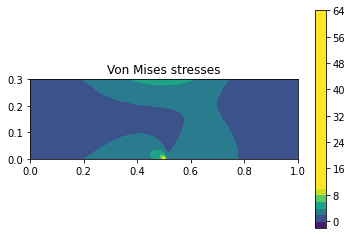

In [13]:
T = dolfin.FunctionSpace(usol.function_space().mesh(), "DG", 1)
sdev = ufl.dev(sigma(eps(usol)))
sigma_mises = dolfin.project(ufl.sqrt(ufl.inner(sdev,sdev)),T)
plt.colorbar(dolfin.plot(sigma_mises,vmax=10))
plt.title("Von Mises stresses")

Calling FFC just-in-time (JIT) compiler, this may take some time.


Text(0, 0.5, '$\\sigma_{yy}$')

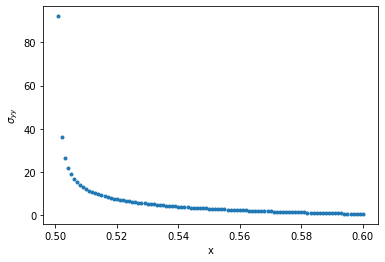

In [14]:
sigma_yy = dolfin.project(sigma(eps(usol))[1,1],T)
xs = np.linspace(0.501,0.6,100)
sigma_yys = np.array([sigma_yy(x,0) for x in xs])
plt.plot(xs,sigma_yys,".")
plt.xlabel("x")
plt.ylabel(r"$\sigma_{yy}$")

Text(0.5, 1.0, 'Stress at the crack tip')

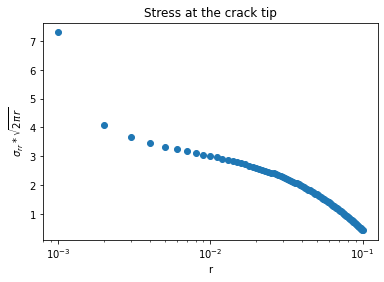

In [15]:
r = (xs-Lc)
r_ = r[np.where(xs>Lc)]
sigma_yys_ = sigma_yys[np.where(xs>Lc)]
plt.semilogx(r_, sigma_yys_ * np.sqrt(2 * np.pi * r_) ,"o")
plt.xlabel("r")
plt.ylabel(r"$\sigma_{rr}*\sqrt{2\pi\,r}$")
plt.title("Stress at the crack tip")


The approximate value of the SIF is $K_I=3.$

In [18]:
G_estimate = 3. ** 2 / E # Irwin's formula in plane stress
print(f"KI_estimate is {3.}, ERR estimate is {G_estimate}")

KI_estimate is 3.0, ERR estimate is 0.9


## Finite differences of the energy

In [20]:

def dcb_dolver(Lc=0.5,n_div=20,n_ref=4,R_ref=0.1,Lx=1.0,H1=0.3,H2=0.3,E=10,nu=0.3):
    mesh = generate_mesh(Lc=0.5,n_div=20,n_ref=4,R_ref=0.1,Lx=1.0,H1=0.3,H2=0.3)
    V = dolfin.VectorFunctionSpace(mesh, "Lagrange", 2)
    
    # Boundary conditions
    u0 = dolfin.Constant(0.0)
    u1 = dolfin.Constant(1)
    bc_bottom = dolfin.DirichletBC(V.sub(1), u0, f"on_boundary & near(x[1],0) && x[0] > {Lc}")
    bc_left = dolfin.DirichletBC(V.sub(1), u1, "on_boundary & near(x[0],0)")
    bc_right = dolfin.DirichletBC(V.sub(0), u0, f"on_boundary & near(x[0],{Lx})")
    bcs = [bc_right, bc_bottom, bc_left]
    
    # Variational formulation of the problem 
    
    u = dolfin.TrialFunction(V)
    v = dolfin.TestFunction(V)

    # bilinear form
    a = dolfin.inner(sigma(eps(u)), eps(v)) * dolfin.dx 
    
    # linear form
    
    # Bulk load 
    bulk_load = dolfin.Constant((0.,0.))
    L = dolfin.inner(bulk_load,v) * dolfin.dx
    
    A = dolfin.assemble(a)
    b = dolfin.assemble(L)
    for bc in bcs:
        bc.apply(A,b)
    
    usol = dolfin.Function(V)
    dolfin.solve(A,usol.vector(),b) 
    energy = 0.5 * dolfin.assemble(dolfin.inner(sigma(eps(usol)), eps(usol)) * dolfin.dx)

    return usol, energy


_, en2 = dcb_dolver(Lc=0.6)
_, en1 = dcb_dolver(Lc=0.5)
- 2 * (en2 - en1)/0.1

0.6974917736414573

# Create the $\theta$-field

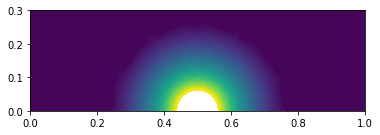

In [21]:
V_theta = dolfin.FunctionSpace(mesh,"P",1)


theta = dolfin.Function(V_theta)
theta_test = dolfin.TestFunction(V_theta)
theta_trial = dolfin.TrialFunction(V_theta)

R_int=Lc/8.
R_ext=Lc/2.

def inner_domain(x):
    return np.sqrt((x[0]-Lc)**2 + x[1]**2) < R_int

def outer_domain(x):
    return np.sqrt((x[0]-Lc)**2 + x[1]**2) > R_ext

one = dolfin.Function(V_theta)
zero = dolfin.Function(V_theta)
one.interpolate(dolfin.Constant(1.))
bc_0 = dolfin.DirichletBC(V_theta, zero, outer_domain)
bc_1 = dolfin.DirichletBC(V_theta, one, inner_domain)

bcs = [bc_0, bc_1]

a = ufl.dot(ufl.grad(theta_trial), ufl.grad(theta_test)) * ufl.dx
L = zero * theta_test * ufl.dx 
A, b = dolfin.assemble_system(a,L,bcs)

dolfin.solve(A,theta.vector(),b)
dolfin.plot(theta)


In [23]:
def create_theta_field(mesh,Lcrack,R_int,R_ext):

    V_theta = dolfin.FunctionSpace(mesh,"P",1)

    theta = dolfin.Function(V_theta)
    theta_test = dolfin.TestFunction(V_theta)
    theta_trial = dolfin.TrialFunction(V_theta)
   
    def inner_domain(x):
        return np.sqrt((x[0]-Lc)**2 + x[1]**2) < R_int
    
    def outer_domain(x):
        return np.sqrt((x[0]-Lc)**2 + x[1]**2) > R_ext
    
    one = dolfin.Function(V_theta)
    zero = dolfin.Function(V_theta)
    one.interpolate(dolfin.Constant(1.))
    bc_0 = dolfin.DirichletBC(V_theta, zero, outer_domain)
    bc_1 = dolfin.DirichletBC(V_theta, one, inner_domain)
        
    bcs = [bc_0, bc_1]
    
    a = ufl.dot(ufl.grad(theta_trial), ufl.grad(theta_test)) * ufl.dx
    L = zero * theta_test * ufl.dx 
    A, b = dolfin.assemble_system(a,L,bcs)
    dolfin.solve(A,theta.vector(),b)
    return theta


In [31]:
Lc1 = 0.5
Lc2 = 0.51
u2, en2 = dcb_dolver(Lc=Lc2)
u1, en1 = dcb_dolver(Lc=Lc1)
ERR_FD = - 2 * (en2 - en1)/ (Lc2 - Lc1)

print(f'The ERR computed with the finite-difference method is {ERR_FD:2.4f}' )


The ERR computed with the finite-difference method is 0.8660


In [33]:
# Define the energy with the change of variables

V = u1.function_space()
theta_ = dolfin.Function(V)
F = ufl.Identity(2) + ufl.grad(theta_)  # Gradient of transformation
eps_ = ufl.sym( ufl.grad(u1) * ufl.inv(F) )
P = 0.5 * ufl.inner(sigma(eps_), eps_) * ufl.det(F) * ufl.dx

thetav = dolfin.project(theta * ufl.as_vector([1,0]),V)

# Leaverage UFL to compute the symbolic derivative  
P_theta = ufl.derivative(P, theta_, thetav)
G_theta_ufl = dolfin.assemble(-2*P_theta)

print(f'The ERR computed with the G-theta method is {G_theta_ufl:2.4f}' )

The ERR computed with the G-theta method is 0.9116


In [41]:
def compute_ERR(u,Lc,Rmin,Rmax):
    
    V = u.function_space()
    
    theta = create_theta_field(V.mesh(),Lc,Rmin,Rmax)
    
    eps_ = eps(u)
    sig_ = sigma(eps_)
    
    thetav = theta * ufl.as_vector([1,0])
    
    first_term = ufl.inner(sig_,ufl.grad(u) * ufl.grad(thetav)) * ufl.dx
    second_term = - 0.5 * ufl.inner(sig_,eps_) * ufl.div(thetav) * ufl.dx
    
    G_theta = 2 * dolfin.assemble(first_term + second_term )
    print(f'The ERR computed with the G-theta method is {G_theta:2.4f}' )
    return G_theta

In [67]:
Ls = np.linspace(.3,.7,10)
ERRs = np.zeros_like(Ls)
energies = np.zeros_like(Ls)
for (i,Lc) in enumerate(Ls):
    usol, energies[i] = dcb_dolver(Lc=Lc)
    ERRs[i] = compute_ERR(usol,Lc,Lc/10.,Lc/4.)

The ERR computed with the G-theta method is 3.2901
The ERR computed with the G-theta method is 2.0562
The ERR computed with the G-theta method is 1.8274
The ERR computed with the G-theta method is 1.3733
The ERR computed with the G-theta method is 1.0444
The ERR computed with the G-theta method is 0.8077
The ERR computed with the G-theta method is 0.6326
The ERR computed with the G-theta method is 0.4718
The ERR computed with the G-theta method is 0.4013
The ERR computed with the G-theta method is 0.2780


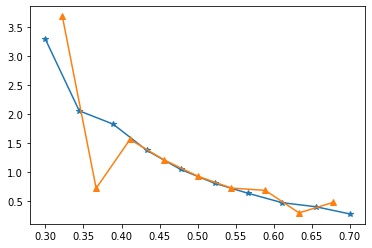

In [68]:
plt.plot(Ls,ERRs,"*-")
plt.plot((Ls[1:] + Ls[:-1]) / 2., - 2 * np.diff(energies)/np.diff(Ls),"^-")